# Predicting Winner of World Cup

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.externals import joblib

C:\Users\radix2016dec\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\radix2016dec\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
import os
print(os.listdir("./"))#shows the data files available in current directory

['.ipynb_checkpoints', 'Untitled.ipynb', 'WorldCupMatches.csv', 'WorldCupPlayers.csv', 'WorldCups.csv']


# Getting and visualizing the Data

In [4]:
matches = pd.read_csv('WorldCupMatches.csv')
matches.head()

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA


In [5]:
players = pd.read_csv('WorldCupPlayers.csv')
cups = pd.read_csv('WorldCups.csv')
matches = matches.dropna()
players = players.dropna()
cups = cups.dropna()

In [6]:
cups.head()

,Year,Country,Winner,Runners-Up,Third,Fourth,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance
0,1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70,13,18,590.549
1,1934,Italy,Italy,Czechoslovakia,Germany,Austria,70,16,17,363.000
2,1938,France,Italy,Hungary,Brazil,Sweden,84,15,18,375.700
3,1950,Brazil,Uruguay,Brazil,Sweden,Spain,88,13,22,1.045.246
4,1954,Switzerland,Germany FR,Hungary,Austria,Uruguay,140,16,26,768.607


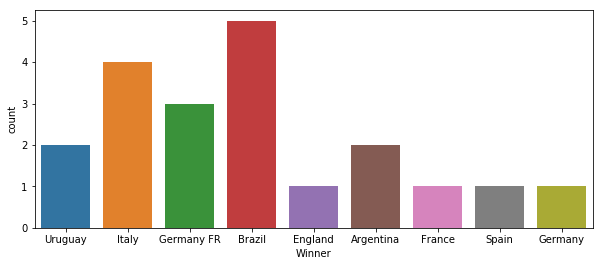

In [7]:
plt.figure(figsize=(10,4))
sns.countplot(cups['Winner'])

In [8]:
def replace_name(df):
    if(df['Home Team Name'] in ['German DR', 'Germany FR']):#replace German DR and Germany FR by Germany
        df['Home Team Name'] = 'Germany'
    elif(df['Home Team Name'] == 'Soviet Union'):#replace Soviet Union by Russia
        df['Home Team Name'] = 'Russia'
    
    if(df['Away Team Name'] in ['German DR', 'Germany FR']):
        df['Away Team Name'] = 'Germany'
    elif(df['Away Team Name'] == 'Soviet Union'):
        df['Away Team Name'] = 'Russia'
    return df
    
matches = matches.apply(replace_name, axis='columns')

print(matches)

       Year              Datetime                     Stage  \
0    1930.0  13 Jul 1930 - 15:00                    Group 1   
1    1930.0  13 Jul 1930 - 15:00                    Group 4   
2    1930.0  14 Jul 1930 - 12:45                    Group 2   
3    1930.0  14 Jul 1930 - 14:50                    Group 3   
4    1930.0  15 Jul 1930 - 16:00                    Group 1   
5    1930.0  16 Jul 1930 - 14:45                    Group 1   
6    1930.0  17 Jul 1930 - 12:45                    Group 2   
7    1930.0  17 Jul 1930 - 14:45                    Group 4   
8    1930.0  18 Jul 1930 - 14:30                    Group 3   
9    1930.0  19 Jul 1930 - 12:50                    Group 1   
10   1930.0  19 Jul 1930 - 15:00                    Group 1   
11   1930.0  20 Jul 1930 - 13:00                    Group 2   
12   1930.0  20 Jul 1930 - 15:00                    Group 4   
13   1930.0  21 Jul 1930 - 14:50                    Group 3   
14   1930.0  22 Jul 1930 - 14:45                    Gro

In [9]:
#create a dictionary of football team
team_name = {}
index = 0
for idx, row in matches.iterrows():
    name = row['Home Team Name']
    if(name not in team_name.keys()):
        team_name[name] = index
        index += 1
    name = row['Away Team Name']
    if(name not in team_name.keys()):
        team_name[name] = index
        index += 1
print(team_name)

{'France': 0, 'Mexico': 1, 'USA': 2, 'Belgium': 3, 'Yugoslavia': 4, 'Brazil': 5, 'Romania': 6, 'Peru': 7, 'Argentina': 8, 'Chile': 9, 'Bolivia': 10, 'Paraguay': 11, 'Uruguay': 12, 'Austria': 13, 'Hungary': 14, 'Egypt': 15, 'Switzerland': 16, 'Netherlands': 17, 'Sweden': 18, 'Germany': 19, 'Spain': 20, 'Italy': 21, 'Czechoslovakia': 22, 'Dutch East Indies': 23, 'Cuba': 24, 'Norway': 25, 'Poland': 26, 'England': 27, 'Scotland': 28, 'Turkey': 29, 'Korea Republic': 30, 'Russia': 31, 'Wales': 32, 'Northern Ireland': 33, 'Colombia': 34, 'Bulgaria': 35, 'Korea DPR': 36, 'Portugal': 37, 'Israel': 38, 'Morocco': 39, 'El Salvador': 40, 'Australia': 41, 'Zaire': 42, 'Haiti': 43, 'Tunisia': 44, 'IR Iran': 45, 'Iran': 46, 'Cameroon': 47, 'New Zealand': 48, 'Algeria': 49, 'Honduras': 50, 'Kuwait': 51, 'Canada': 52, 'Iraq': 53, 'Denmark': 54, 'rn">United Arab Emirates': 55, 'Costa Rica': 56, 'rn">Republic of Ireland': 57, 'Saudi Arabia': 58, 'Greece': 59, 'Nigeria': 60, 'South Africa': 61, 'Japan': 6

# Data Cleaning

In [10]:
#drop unecessary columns
dropped_matches = matches.drop(['Datetime', 'Stadium', 'Referee', 'Assistant 1', 'Assistant 2', 'RoundID','Win conditions',
             'Home Team Initials', 'Away Team Initials', 'Half-time Home Goals', 'Half-time Away Goals',
             'Attendance', 'City', 'MatchID', 'Stage'], 1)

In [11]:
#Make a serie counting the number of time each team became WC champion
championships = cups['Winner'].map(lambda p: 'Germany' if p=='Germany FR' else p).value_counts()
championships

Brazil       5
Italy        4
Germany      4
Argentina    2
Uruguay      2
France       1
England      1
Spain        1
Name: Winner, dtype: int64

In [12]:
#append 'Home Team Championships' and 'Away Team Championships': Number of times being the champion of WC
dropped_matches['Home Team Championship'] = 0
dropped_matches['Away Team Championship'] = 0
def count_championship(df):
  if(championships.get(df['Home Team Name']) != None):
    df['Home Team Championship'] = championships.get(df['Home Team Name'])
  if(championships.get(df['Away Team Name']) != None):
    df['Away Team Championship'] = championships.get(df['Away Team Name'])
  return df
dropped_matches = dropped_matches.apply(count_championship, axis='columns')
dropped_matches

,Year,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Home Team Championship,Away Team Championship
0,1930.0,France,4.0,1.0,Mexico,1,0
1,1930.0,USA,3.0,0.0,Belgium,0,0
2,1930.0,Yugoslavia,2.0,1.0,Brazil,0,5
3,1930.0,Romania,3.0,1.0,Peru,0,0
4,1930.0,Argentina,1.0,0.0,France,2,1
5,1930.0,Chile,3.0,0.0,Mexico,0,0
6,1930.0,Yugoslavia,4.0,0.0,Bolivia,0,0
7,1930.0,USA,3.0,0.0,Paraguay,0,0
8,1930.0,Uruguay,1.0,0.0,Peru,2,0
9,1930.0,Chile,1.0,0.0,France,0,1


In [13]:
#find who won: Home win: 1, Away win: 2, Draw: 0
dropped_matches['Winner'] = '-'
def find_winner(df):
    if(int(df['Home Team Goals']) == int(df['Away Team Goals'])):
        df['Winner'] = 0
    elif(int(df['Home Team Goals']) > int(df['Away Team Goals'])):
        df['Winner'] = 1
    else:
        df['Winner'] = 2
    return df
dropped_matches = dropped_matches.apply(find_winner, axis='columns')
dropped_matches

,Year,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Home Team Championship,Away Team Championship,Winner
0,1930.0,France,4.0,1.0,Mexico,1,0,1
1,1930.0,USA,3.0,0.0,Belgium,0,0,1
2,1930.0,Yugoslavia,2.0,1.0,Brazil,0,5,1
3,1930.0,Romania,3.0,1.0,Peru,0,0,1
4,1930.0,Argentina,1.0,0.0,France,2,1,1
5,1930.0,Chile,3.0,0.0,Mexico,0,0,1
6,1930.0,Yugoslavia,4.0,0.0,Bolivia,0,0,1
7,1930.0,USA,3.0,0.0,Paraguay,0,0,1
8,1930.0,Uruguay,1.0,0.0,Peru,2,0,1
9,1930.0,Chile,1.0,0.0,France,0,1,1


In [14]:
def replace_team_name_by_id(df):
    df['Home Team Name'] = team_name[df['Home Team Name']]
    df['Away Team Name'] = team_name[df['Away Team Name']]
    #df['Winner'] = team_name[df['Winner']]
    return df

teamid_matches = dropped_matches.apply(replace_team_name_by_id, axis='columns')
teamid_matches

,Year,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Home Team Championship,Away Team Championship,Winner
0,1930.0,0,4.0,1.0,1,1,0,1
1,1930.0,2,3.0,0.0,3,0,0,1
2,1930.0,4,2.0,1.0,5,0,5,1
3,1930.0,6,3.0,1.0,7,0,0,1
4,1930.0,8,1.0,0.0,0,2,1,1
5,1930.0,9,3.0,0.0,1,0,0,1
6,1930.0,4,4.0,0.0,10,0,0,1
7,1930.0,2,3.0,0.0,11,0,0,1
8,1930.0,12,1.0,0.0,7,2,0,1
9,1930.0,9,1.0,0.0,0,0,1,1


In [15]:
#drop unecessary columns
teamid_matches = teamid_matches.drop(['Year', 'Home Team Goals', 'Away Team Goals'], 1)
teamid_matches

,Home Team Name,Away Team Name,Home Team Championship,Away Team Championship,Winner
0,0,1,1,0,1
1,2,3,0,0,1
2,4,5,0,5,1
3,6,7,0,0,1
4,8,0,2,1,1
5,9,1,0,0,1
6,4,10,0,0,1
7,2,11,0,0,1
8,12,7,2,0,1
9,9,0,0,1,1


In [16]:
X = teamid_matches.loc[:,['Home Team Name', 'Away Team Name', 'Home Team Championship','Away Team Championship']]
X = np.array(X).astype('float64')
_X = X.copy()

_X[:,0] = X[:,1]
_X[:,1] = X[:,0]
_X[:,2] = X[:,3]
_X[:,3] = X[:,2]

y = dropped_matches.loc[:,['Winner']]
y = np.array(y).astype('int')
y = np.reshape(y,(1,850))
y = y[0]
_y = y.copy()
for i in range(len(_y)):
  if(_y[i]==1):
    _y[i] = 2
  elif(_y[i] ==2):
    _y[i] = 1
X = np.concatenate((X,_X), axis= 0)
y = np.concatenate((y,_y))   

# spliting test and train data

In [17]:
X,y = shuffle(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(y_train)

[1 2 2 ... 0 0 2]


In [18]:
param_grid = {'C': [1e3],
              'gamma': [0.0001] }
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
svm_model.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
print("Predicting on the test set")
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels=range(3)))

Predicting on the test set
             precision    recall  f1-score   support

          0       0.60      0.74      0.66        98
          1       0.77      0.76      0.76       154
          2       0.85      0.74      0.79       173

avg / total       0.76      0.75      0.75       425

[[ 73  12  13]
 [ 27 117  10]
 [ 22  23 128]]


In [31]:
def prediction(team1, team2):
  id1 = team_name[team1]
  id2 = team_name[team2]
  championship1 = championships.get(team1) if championships.get(team1) != None else 0
  championship2 = championships.get(team2) if championships.get(team2) != None else 0

  x = np.array([id1, id2, championship1, championship2]).astype('float64')
  x = np.reshape(x, (1,-1))
  _y = svm_model.predict_proba(x)[0]

  text = ('Chance for '+team1+' to win '+team2+' is {}\nChance for '+team2+' to win '+team1+' is {}\nChance for '+team1+' and '+team2+' draw is {}').format(_y[1]*100,_y[2]*100,_y[0]*100)
  return _y[0], text

In [32]:
# match between France and Uruguay
prob1, text1 = prediction('France', 'Uruguay')
print(text1)

Chance for France to win Uruguay is 27.133138973045867
Chance for Uruguay to win France is 43.75288839212442
Chance for France and Uruguay draw is 29.113972634829743


In [33]:
# match between Brazil and Belgium
prob2, text2 = prediction('Brazil','Belgium')
print(text2)

Chance for Brazil to win Belgium is 51.24470558631735
Chance for Belgium to win Brazil is 23.025906881328954
Chance for Brazil and Belgium draw is 25.729387532353698


In [34]:
# matches between England and Sweeden
prob3, text3 = prediction('England','Sweden')
print(text3)

Chance for England to win Sweden is 47.312185433455994
Chance for Sweden to win England is 23.684540928190113
Chance for England and Sweden draw is 29.00327363835391


# From this we have predicted that which country will won the Fifa World cup